# Определение возраста покупателей

Поздравляем! Вы прошли курс в тренажёре. Самое время проверить знания и решить новую задачу. Выполнять работу будете самостоятельно.  
Когда закончите, отправьте её на проверку ревьюеру: он пришлёт комментарии в течение суток. После этого нужно доработать проект и пройти повторную проверку. 
Скорее всего, вы будете дорабатывать кейс по комментариям ещё несколько раз. Это нормально. 
Проект завершён, когда ревьюер одобрит все доработки. 

### Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Возраст клиентов магазина

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Средний возраст клиентов и медианный вочти совпадают (около 30 лет). Самому молодому клиенту 1 год, а самому пожилому - 100 лет.

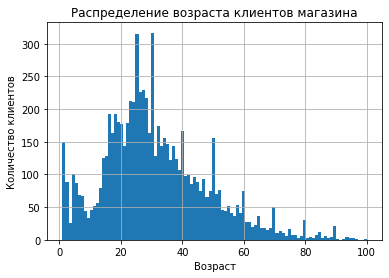

In [5]:
df.hist(bins=100)
plt.title('Распределение возраста клиентов магазина')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

Как можно видеть из графика, большвя часть клиентов магазина имеют возраст 20-40 лет.

### Вывод изображений

Созданим и настроем загрузчик данных.

In [6]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)

In [7]:
datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345)

Found 5694 images belonging to 1 classes.


In [8]:
features, target = next(datagen_flow)

Выведем на экран несколько изображений с лицами клиентов.

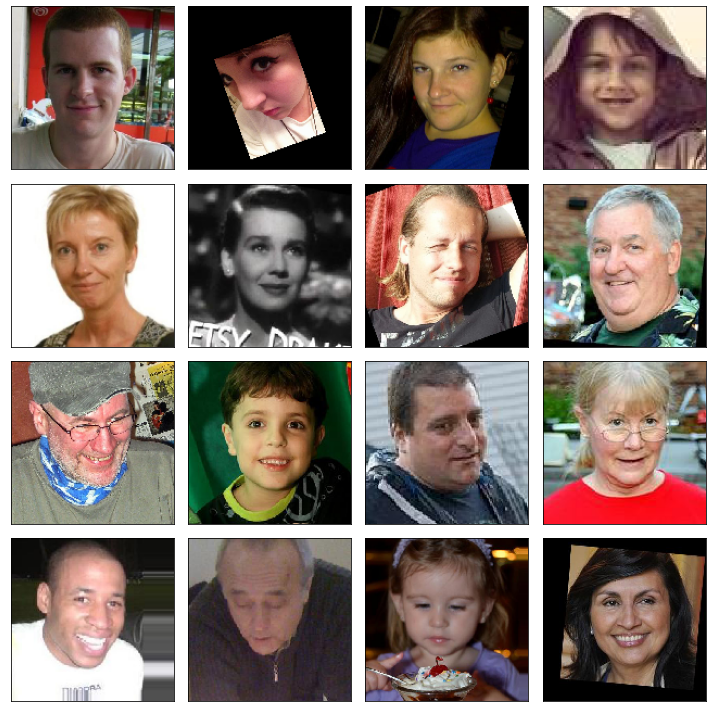

In [13]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Изображения выводятся нормально. Загрузчик адаптирует изображения при помощи поворотоы и масштабирования.

###  Выводы раздела

- Данные и изобрвжкемя клиентов  загружаются нормально. 
- Размер датвсета составляет 7591 изображение. Такого количества примеров достаточно для разделения на выборки и обучение модели.
- Средний возраст клиентов и медианный вочти совпадают (около 30 лет). Самому молодому клиенту 1 год, а самому пожилому - 100 лет. Большвя часть клиентов магазина имеют возраст 20-40 лет. С определением возраста детей и пожилых могут возникнуть небольшие сложности. 
- Выгруженные примеры изображений показывают, что необходим ряд аугментаций.

## Обучение модели

Перенесём код обучения модели и её результат вывода на экран.

### Код

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def load_train(path):
    print('Загрузка обучающих данных')
    #t_data=pd.read_csv(path+'labels.csv')
    t_data=pd.read_csv(path+'labels.csv')
    #print('go', t_data.shape)
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1/255) 
    train_datagen_flow = train_datagen.flow_from_dataframe(
                                    dataframe=t_data,
                                    directory=path + 'final_files',
                                    #directory='/datasets/faces/final_files/',
                                    x_col='file_name',
                                    y_col='real_age',
                                  #  '/datasets/fruits_small/',
                                    target_size=(224, 224),
                                    batch_size=32,
                                    class_mode='raw',
                                    subset='training',
                                    seed=12345)
    print('Обучающие данные загружены')  
    return train_datagen_flow

def load_test(path):
    print('Загрузка тестовых данных')
    #t_data=pd.read_csv(path+'/datasets/faces/labels.csv')
    t_data=pd.read_csv(path+'labels.csv')
    #print('go', t_data.shape)
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    val_datagen_flow = validation_datagen.flow_from_dataframe(
                                    dataframe=t_data,
                                    #directory='/datasets/faces/final_files/',
                                    directory=path + 'final_files',
                                    x_col='file_name',
                                    y_col='real_age',
                                    target_size=(224, 224),
                                    batch_size=32,
                                    class_mode='raw',
                                    subset='validation',
                                    seed=12345)
    print('Тестовые данные загружены')  
    return val_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        #'/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)


    # замораживаем ResNet50 без верхушки
    #backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model    
    
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=0.005):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)  

    return model
```

### Результат вывода на экран

```
Загрузка обучающих данных
Found 5694 validated image filenames.
Обучающие данные загружены
Загрузка тестовых данных
Found 1897 validated image filenames.
Тестовые данные загружены

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 38s
   90112/94765736 [..............................] - ETA: 57s
  270336/94765736 [..............................] - ETA: 39s
  811008/94765736 [..............................] - ETA: 18s
 2310144/94765736 [..............................] - ETA: 8s 
 4849664/94765736 [>.............................] - ETA: 4s
 9412608/94765736 [=>............................] - ETA: 2s
13664256/94765736 [===>..........................] - ETA: 2s
17252352/94765736 [====>.........................] - ETA: 1s
21618688/94765736 [=====>........................] - ETA: 1s
26050560/94765736 [=======>......................] - ETA: 1s
29523968/94765736 [========>.....................] - ETA: 1s
33718272/94765736 [=========>....................] - ETA: 1s
38346752/94765736 [===========>..................] - ETA: 0s
41787392/94765736 [============>.................] - ETA: 0s
45703168/94765736 [=============>................] - ETA: 0s
50757632/94765736 [===============>..............] - ETA: 0s
54108160/94765736 [================>.............] - ETA: 0s
58032128/94765736 [=================>............] - ETA: 0s
63037440/94765736 [==================>...........] - ETA: 0s
66568192/94765736 [====================>.........] - ETA: 0s
70164480/94765736 [=====================>........] - ETA: 0s
75046912/94765736 [======================>.......] - ETA: 0s
78839808/94765736 [=======================>......] - ETA: 0s
82493440/94765736 [=========================>....] - ETA: 0s
87113728/94765736 [==========================>...] - ETA: 0s
91201536/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 0.005 steps
Epoch 1/10
178/178 - 37s - loss: 224.6699 - mae: 10.7055 - val_loss: 188821.2402 - val_mae: 24.0445
Epoch 2/10
178/178 - 28s - loss: 59.8490 - mae: 5.8670 - val_loss: 152645.1416 - val_mae: 20.2252
Epoch 3/10
178/178 - 29s - loss: 30.1223 - mae: 4.2422 - val_loss: 72554.6387 - val_mae: 11.7251
Epoch 4/10
178/178 - 28s - loss: 21.3903 - mae: 3.5434 - val_loss: 24076.5533 - val_mae: 7.6904
Epoch 5/10
178/178 - 29s - loss: 15.1192 - mae: 3.0229 - val_loss: 14508.9615 - val_mae: 6.6607
Epoch 6/10
178/178 - 28s - loss: 11.7575 - mae: 2.6601 - val_loss: 11110.0906 - val_mae: 5.6725
Epoch 7/10
178/178 - 31s - loss: 10.2069 - mae: 2.4628 - val_loss: 11933.5907 - val_mae: 6.0374
Epoch 8/10
178/178 - 31s - loss: 9.3720 - mae: 2.3331 - val_loss: 12776.8875 - val_mae: 6.2449
Epoch 9/10
178/178 - 33s - loss: 9.0613 - mae: 2.2644 - val_loss: 9127.0172 - val_mae: 5.2881
Epoch 10/10

178/178 - 32s - loss: 8.1075 - mae: 2.1462 - val_loss: 11164.7514 - val_mae: 5.6581

60/60 - 11s - loss: 68.7729 - mae: 6.2095
Test MAE: 6.2095
```

###  Выводы раздела

Модель корректно загружает данные и эффективно обучается.

## Анализ обученной модели

Визуализируем результаты обучения.

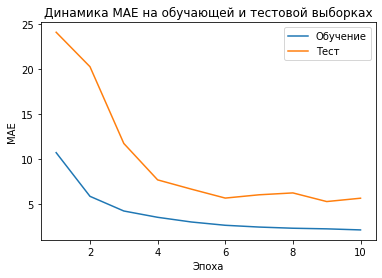

In [15]:
train_score = [10.7055, 5.8670, 4.2422,3.5434,3.0229,2.6601,2.4628,2.3331,2.2644,2.1462]
test_score = [24.0445,20.2252,11.7251,7.6904,6.6607,5.6725,6.0374,6.2449,5.2881,5.6581]
epochs = [1,2,3,4,5,6,7,8,9,10]

plt.plot(epochs, train_score,label='Обучение')
plt.plot(epochs, test_score, label='Тест')
plt.legend()
plt.title('Динамика MAE на обучающей и тестовой выборках')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.show()

В этом разделе стоит опишем используемые для создания и обучения модели подходы:
    
**Использованная архитектура:**

- ResNet с 50 слоями. Бэкбон +  два слоя (GlobalAveragePooling2D и Dense) в конце. 
 
**Иинициализация весов:**

 - Для улучшения качества обучения были загружены веса сети датасета `ImageNet`.
 
**Параметры обучения:**

- размер батча `32`, 
- оптимизатор `Adam` с `lr` = `0.0001`, 
- заморозка весов бэкбона не использовалась,  
- количество эпох равно `10`.

**Метрики:**

- в качестве функции потерь использовалась `MSE`;
- достигнутые необходимое значение метрики качества `MAE`;
- переобучение не наблюдалось.

Как можно видеть значения MAE на тестово выборке несколько выше, чем на обучающей. Однако мы добились нужных значений.

### Выводы раздела

*Выводы:* Мы построили и обучили свёрточную нейронную сеть *ResNet* на датасете с фотографиями людей. Мы добмомчт значения MAE на тестовой выборке меньше 8, а именно 6.2095.

## Итоговые воводы

- Данные и изобрвжкемя клиентов загружаются нормально. Основная возрвстнвя категория клиентов 20-40 лет. С определением возраста детей и пожилых могут возникнуть небольшие сложности. Изображения

- Мы построили и обучили свёрточную нейронную сеть *ResNet* на датасете с фотографиями людей.

- Модель корректно загружает данные и эффективно обучается.

- Мы добмомчт значения MAE на тестовой выборке меньше 8, а именно 6.2095.